In [2]:
from cryptory import Cryptory

In [3]:
my_cryptory = Cryptory(from_date="2013-04-28")

In [4]:
my_cryptory

<cryptory.cryptory.Cryptory instance at 0x7fe63d7b8fc8>

In [5]:
# Daily data from coinmarketcap
bitcoin_market_info = my_cryptory.extract_coinmarketcap("bitcoin")
bitcoin_market_info.loc[bitcoin_market_info['date'] == '2018-01-25' ]

,date,open,high,low,close,volume,marketcap
233,2018-01-25,11421.7,11785.7,11057.4,11259.4,8873169920,192162840576


In [6]:
# Daily subscriber numbers to the bitcoin reddit page
# my_cryptory.extract_reddit_metrics(subreddit="bitcoin", metric="total-subscribers")

In [7]:
# Google Trends - bitcoin search results
# my_cryptory.get_google_trends(kw_list=["bitcoin"])

In [8]:
# dow jones price (market code from yahoo finance)
# my_cryptory.get_stock_prices(market="%5EDJI")

In [9]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [10]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [11]:
# get historical commodity prices
# my_cryptory.get_metal_prices()

In [12]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Func to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_inititial_rows(api, start_date='2013-04-28'):
    # Read data 
    api_range_format= api+'?timespan=all&format=csv'
#     print(api_range_format)
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', 'avg_block_size'])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    elif 'transactions' in api:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', 'transactions'])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [13]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

In [14]:
####################################################################################################################
######## Getting Blockchain data
####################################################################################################################

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size" 
avg_block_size = drop_inititial_rows(block_size_api)
print(avg_block_size)

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions" 
txs = drop_inititial_rows(txs_api)

           date avg_block_size
0    2013-04-28       0.126539
1    2013-04-29       0.126539
2    2013-04-30       0.185539
3    2013-05-01       0.185539
4    2013-05-02       0.189949
5    2013-05-03       0.189949
6    2013-05-04       0.156482
7    2013-05-05       0.156482
8    2013-05-06       0.160476
9    2013-05-07       0.160476
10   2013-05-08       0.153979
11   2013-05-09       0.153979
12   2013-05-10        0.19619
13   2013-05-11        0.19619
14   2013-05-12       0.181254
15   2013-05-13       0.181254
16   2013-05-14       0.201062
17   2013-05-15       0.201062
18   2013-05-16       0.209041
19   2013-05-17       0.209041
20   2013-05-18       0.166721
21   2013-05-19       0.166721
22   2013-05-20       0.166632
23   2013-05-21       0.166632
24   2013-05-22       0.157969
25   2013-05-23       0.157969
26   2013-05-24       0.162238
27   2013-05-25       0.162238
28   2013-05-26       0.132648
29   2013-05-27       0.132648
...         ...            ...
1937 201

In [45]:
####################################################################################################################
######## Getting Exchange Data, Sentiment Data (Reddit & Google Trends), Fin. Indecies (Yahoo), USD & EUR Exchanges
####################################################################################################################
my_cryptory = Cryptory(from_date="2013-04-28")

btc_market_info = my_cryptory.extract_coinmarketcap('bitcoin')[['date','close','volume']]
rename_columns('bt_', btc_market_info)

# # Get volume, and rest of data

btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
rename_columns('google_trends_', btc_google_trends)

# Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

# Dow Jones price (market code)
dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
# Testing purposes
dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]

# # Exchange rates
eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

# Left out reddit
# btc_final = btc_market_info.merge(btc_google_trends, on='date', how='inner').merge(btc_reddit_subscribers,on='date', how='inner'). \
#             merge(dow_jones_stock,on='date' ,how='inner'). \
#             merge(eur_usd_exchange_rate, on='date', how='inner'). \
#             merge(avg_block_size, on='date', how='inner')


btc_final = btc_market_info.merge(btc_google_trends, on='date', how='inner'). \
            merge(dow_jones_stock,on='date' ,how='inner'). \
            merge(avg_block_size, on='date', how='inner')

# Need to scale columns (min-max scaling)
btc_final[['google_trends_bitcoin','bt_close', 'bt_volume', 'close', 'avg_block_size']] = (
        btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'close', 'avg_block_size']]- \
        btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'close', 'avg_block_size']].min())/(
        btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'close', 'avg_block_size']].max()- \
        btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'close', 'avg_block_size']].min())

btc_final.to_csv('btc_data_reconciliation.csv')

# # Need to scale columns (min-max scaling)
# btc_final[['google_trends_bitcoin','bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']] = (
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']]- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())/(
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].max()- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())


# Alternatively, we could have scaled with scikit
# from sklearn.preprocessing import minmax_scale
# btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']] = minmax_scale(btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']])

In [46]:
# Get rid of rows where volume is 0
btc_final = btc_final[btc_final['bt_volume']!=0]

In [47]:
split_date = '2018-01-03' # Therefore, the test dataset has values from 2018-01-03 to 2018-09-13

# we don't need the date columns anymore
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
# print(training_set)
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [62]:
window_len = 30
norm_cols = ['bt_close','bt_volume']
print(norm_cols)

['bt_close', 'bt_volume']


In [63]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [64]:
print(LSTM_training_inputs[0])

     bt_close  bt_volume  google_trends_bitcoin     close avg_block_size
255  0.000000   0.000000               0.305396  0.850073       0.930218
256 -0.088838  -0.389123               0.265129  0.841309       0.926066
257 -0.055365  -0.279599               0.275196  0.841309       0.926066
258 -0.136110  -0.142106               0.325530  0.841309       0.936369
259 -0.021852  -0.226817               0.325530  0.841309       0.936369
260 -0.025185  -0.267716               0.375863  0.851202        0.95548
261  0.057424  -0.258747               0.365797  0.845916        0.95548
262  0.074945  -0.201364               0.395997  0.843566       0.939251
263 -0.064069  -0.366952               0.395997  0.844223       0.939251
264 -0.070828  -0.313078               0.466464  0.844223       0.948201
265 -0.018969  -0.223226               0.617465  0.844223       0.948201
266 -0.077131   0.317655               1.000000  0.844223       0.927641
267  0.055037  -0.019589               0.516797  0.

In [65]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[-3.16854637e-02 -4.92488618e-02 -8.63071887e-03  2.38294388e-04
 -5.42541689e-03 -1.86363906e-02  5.55821715e-02 -2.52037933e-02
  3.46632120e-02  2.36407709e-02 -4.01989242e-02 -3.15936721e-02
  2.24407957e-02  5.24785188e-02  8.42757008e-02  1.16097427e-01
  1.62396310e-01  1.59676146e-01  1.91823609e-01  2.19579354e-01
  1.77510471e-01  2.19713359e-01  2.92183501e-01  2.11531511e-01
  1.44810313e-01  1.78003558e-01  1.31734611e-01  1.64129951e-01
  1.21333804e-01  1.57399103e-01  6.94268833e-02  2.60842760e-02
 -3.44349300e-03 -1.35331758e-02 -1.07462303e-02  3.43345955e-02
 -3.66595895e-02  6.98932403e-02  3.10560400e-03 -1.37824932e-02
 -5.64253112e-02 -5.65316279e-02 -1.13609088e-01 -1.38364948e-01
 -1.33756723e-01 -1.80837421e-01 -2.18992733e-01 -2.45417502e-01
 -2.81731768e-01 -2.47991127e-01 -2.35681168e-01 -2.38163383e-01
 -2.69397212e-01 -2.02629182e-01 -1.81603960e-01 -9.38053507e-02
 -7.92758417e-02 -9.41983637e-02 -8.70897725e-02 -1.13306796e-01
 -2.87098476e-02  1.54088

In [66]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [67]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="tanh",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [70]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 20
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

30
5
Epoch 1/50
 - 28s - loss: 0.1261
Epoch 2/50
 - 20s - loss: 0.0992
Epoch 3/50
 - 21s - loss: 0.0948
Epoch 4/50
 - 20s - loss: 0.0926
Epoch 5/50
 - 23s - loss: 0.0917
Epoch 6/50
 - 21s - loss: 0.0913
Epoch 7/50
 - 21s - loss: 0.0910
Epoch 8/50
 - 21s - loss: 0.0898
Epoch 9/50
 - 20s - loss: 0.0897
Epoch 10/50
 - 21s - loss: 0.0896
Epoch 11/50
 - 21s - loss: 0.0887
Epoch 12/50
 - 22s - loss: 0.0887
Epoch 13/50
 - 21s - loss: 0.0893
Epoch 14/50
 - 20s - loss: 0.0870
Epoch 15/50
 - 20s - loss: 0.0884
Epoch 16/50
 - 20s - loss: 0.0876
Epoch 17/50
 - 20s - loss: 0.0867
Epoch 18/50
 - 19s - loss: 0.0857
Epoch 19/50
 - 20s - loss: 0.0868
Epoch 20/50
 - 20s - loss: 0.0864
Epoch 21/50
 - 19s - loss: 0.0850
Epoch 22/50
 - 20s - loss: 0.0864
Epoch 23/50
 - 20s - loss: 0.0846
Epoch 24/50
 - 20s - loss: 0.0846
Epoch 25/50
 - 20s - loss: 0.0834
Epoch 26/50
 - 20s - loss: 0.0854
Epoch 27/50
 - 19s - loss: 0.0839
Epoch 28/50
 - 20s - loss: 0.0842
Epoch 29/50
 - 20s - loss: 0.0831
Epoch 30/50
 - 20s

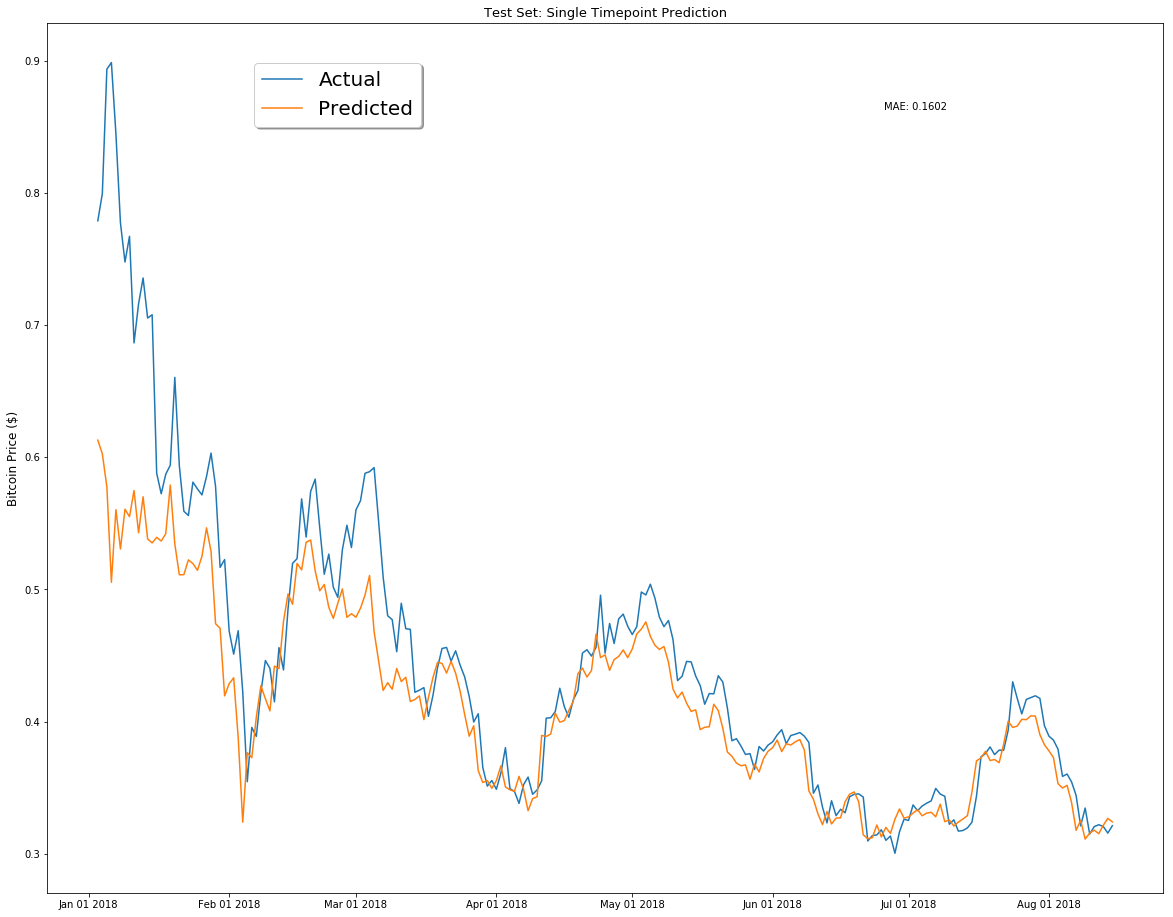

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
# rcParams['font.size'] = 14
# rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

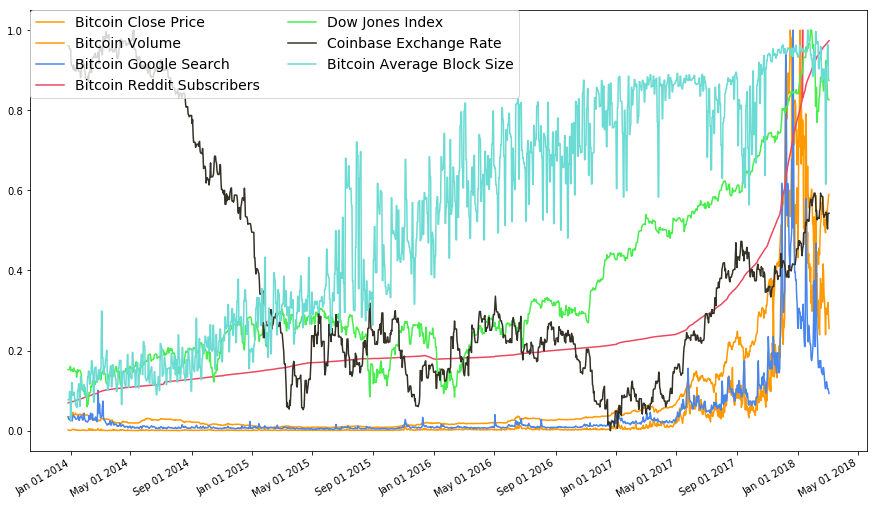

In [25]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(15, 9)) # 1 row 1 col

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2013,2019)])

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_close'], label='Bitcoin Close Price', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_volume'], label='Bitcoin Volume', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['google_trends_bitcoin'], label="Bitcoin Google Search", color='#4885ed')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['reddit_total_subscribers'], label="Bitcoin Reddit Subscribers", color='#ed475e')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['adjclose'], label="Dow Jones Index", color='#47ed4c')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['exch_rate'], label="Coinbase Exchange Rate", color='#353127')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['avg_block_size'], label="Bitcoin Average Block Size", color='#6bdbd3')

ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

In [17]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np

def build_model(inputs, output_size, neurons, activ_func = "linear",
                dropout =0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


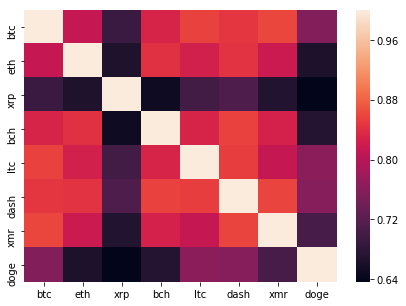

In [21]:
# Pearson correlation on all data sources
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2018-01-01")
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

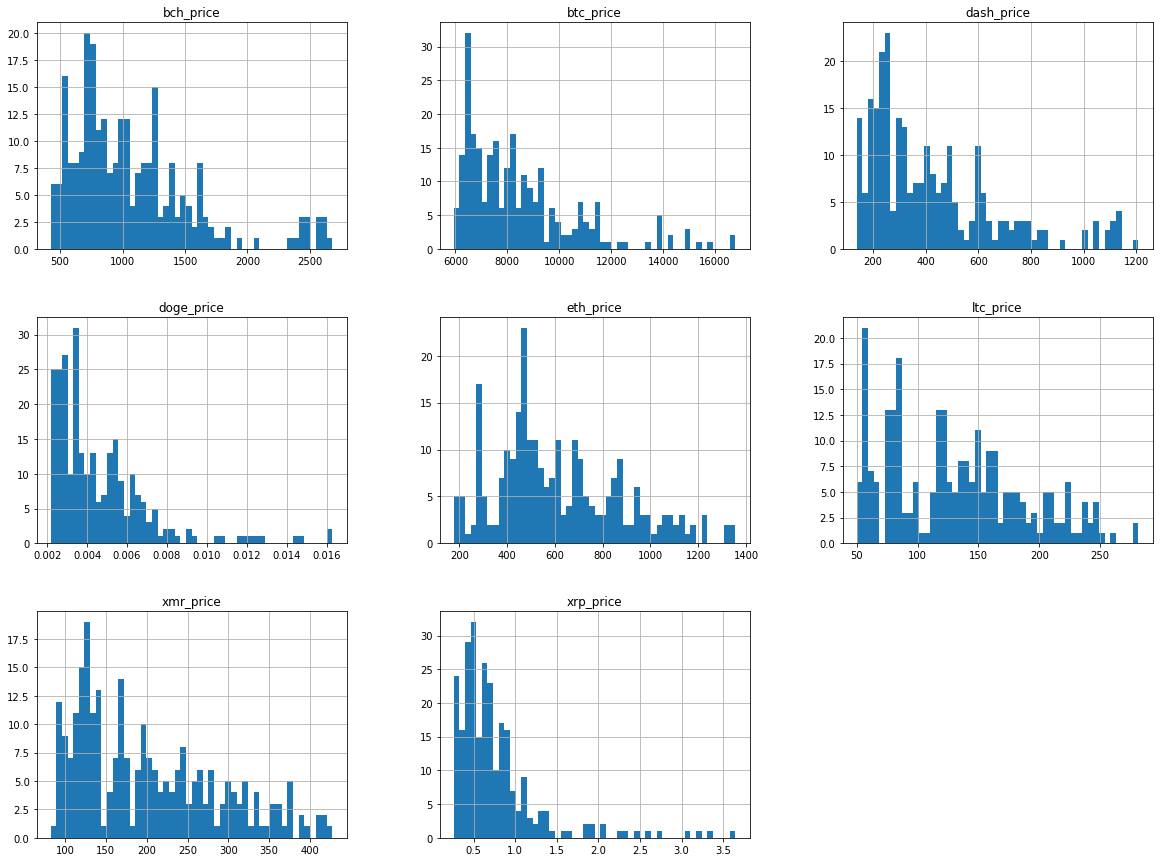

In [22]:
import matplotlib.pyplot as plt
all_coins_df.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2018, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()